# NHL Fight Data Analysis

### In this notebook, we have analyzed the relationship between game outcomes like goal scoring, puck possession, unblocked shot attempts, match-winning, etc., with fights between players of different teams. 

### Further, we have also compared and performed a correlation analysis between teams' performance in the following two matches after they fought in their previous game to understand the psychological impact of a fistfight on the team.

#### Imported the required libraries

In [1]:
import numpy as np
import pandas as pd
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
from matplotlib.pyplot import figure

warnings.filterwarnings("ignore")

In [2]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', 0)

#### Load Data

In [3]:
fight = pd.read_csv('data/fight_table.csv')

In [4]:
fight['date_of_fight'] = pd.to_datetime(fight['date_of_fight'])
fight['digits'] = fight.apply(lambda row: re.findall("\d*\.*\d+", row['winner']), axis=1)
fight['Voted winner (%)'] = fight.apply(lambda row: row['digits'][0], axis=1)
fight['Voted rating'] = fight.apply(lambda row: row['digits'][1], axis=1)
del fight['digits']

In [5]:
fight.head(5)

,date_of_fight,idk_column,player1_name,player1_team,player2_name,player2_team,winner,Voted winner (%),Voted rating
0,2000-04-09,3 Pd 7:47,Dale Purinton,NYR,Keith Primeau,PHI,Voted winner: Keith Primeau (50%) - Voted rati...,50,4
1,2000-04-09,3 Pd 10:1,Andre Roy,OTT,Cory Sarich,TBL,Voted winner: Draw (50%) - Voted rating: 0,50,0
2,2000-04-09,1 Pd 6:13,Andre Roy,OTT,Kyle Freadrich,TBL,Voted winner: Kyle Freadrich (100%) - Voted ra...,100,5
3,2000-04-08,3 Pd 19:37,Clarke Wilm,CAL,Dan LaCouture,EDM,Voted winner: Draw (50%) - Voted rating: 0,50,0
4,2000-04-08,1 Pd 15:18,D.J. Smith,TOR,Gordie Dwyer,TBL,Voted winner: Gordie Dwyer (100%) - Voted rati...,100,10


In [6]:
fight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_of_fight     10819 non-null  datetime64[ns]
 1   idk_column        10819 non-null  object        
 2   player1_name      10819 non-null  object        
 3   player1_team      10819 non-null  object        
 4   player2_name      10819 non-null  object        
 5   player2_team      10819 non-null  object        
 6   winner            10819 non-null  object        
 7   Voted winner (%)  10819 non-null  object        
 8   Voted rating      10819 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 760.8+ KB


In [7]:
fight.describe()

,date_of_fight,idk_column,player1_name,player1_team,player2_name,player2_team,winner,Voted winner (%),Voted rating
count,10819,10819,10819,10819,10819,10819,10819,10819,10819
unique,3091,3285,1422,33,1467,33,9023,887,748
top,2002-01-19 00:00:00,3 Pd 20:0,Jody Shelley,BOS,Cody McLeod,ANA,Voted winner: Draw (50%) - Voted rating: 0,50,0
freq,20,72,99,476,84,514,1141,1907,1141
first,1999-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-02-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
display(fight['player1_team'].unique())
print('Count:', fight['player1_team'].unique().size)

array(['NYR', 'OTT', 'CAL', 'TOR', 'NSH', 'STL', 'MON', 'VAN', 'EDM',
       'TBL', 'FLA', 'ATL', 'PIT', 'NJD', 'COL', 'WAS', 'PHI', 'DET',
       'SJS', 'DAL', 'BUF', 'LAK', 'NYI', 'BOS', 'CHI', 'CAR', 'ARI',
       'ANA', 'MIN', 'CBJ', 'WPG', 'VGK', 'SEA'], dtype=object)

Count: 33


In [9]:
display(fight['player2_team'].unique())
print('Count:', fight['player2_team'].unique().size)

array(['PHI', 'TBL', 'EDM', 'COL', 'ANA', 'CHI', 'LAK', 'PIT', 'BOS',
       'NJD', 'NYI', 'ARI', 'DET', 'ATL', 'TOR', 'DAL', 'NYR', 'CAL',
       'MON', 'CAR', 'FLA', 'VAN', 'STL', 'BUF', 'WAS', 'OTT', 'SJS',
       'NSH', 'CBJ', 'MIN', 'WPG', 'VGK', 'SEA'], dtype=object)

Count: 33


In [10]:
intersection = pd.Series(list(set(fight['player1_team']).intersection(set(fight['player2_team']))))
display(intersection.count())

33

#### Since one dataset had full team names and other had abbreviations, we need to map the team names with it's abbreviations.

In [11]:
team_info = pd.read_json('data/teams_info.json')
team_name = [list(team_info.teams[idx].values())[1] for idx in range (team_info.shape[0])]
abbr = [list(team_info.teams[idx].values())[4] for idx in range (team_info.shape[0])]
mapping = {key:value for key, value in zip (abbr, team_name)}
mapping

{'NJD': 'New Jersey Devils',
 'NYI': 'New York Islanders',
 'NYR': 'New York Rangers',
 'PHI': 'Philadelphia Flyers',
 'PIT': 'Pittsburgh Penguins',
 'BOS': 'Boston Bruins',
 'BUF': 'Buffalo Sabres',
 'MTL': 'Montréal Canadiens',
 'OTT': 'Ottawa Senators',
 'TOR': 'Toronto Maple Leafs',
 'CAR': 'Carolina Hurricanes',
 'FLA': 'Florida Panthers',
 'TBL': 'Tampa Bay Lightning',
 'WSH': 'Washington Capitals',
 'CHI': 'Chicago Blackhawks',
 'DET': 'Detroit Red Wings',
 'NSH': 'Nashville Predators',
 'STL': 'St. Louis Blues',
 'CGY': 'Calgary Flames',
 'COL': 'Colorado Avalanche',
 'EDM': 'Edmonton Oilers',
 'VAN': 'Vancouver Canucks',
 'ANA': 'Anaheim Ducks',
 'DAL': 'Dallas Stars',
 'LAK': 'Los Angeles Kings',
 'SJS': 'San Jose Sharks',
 'CBJ': 'Columbus Blue Jackets',
 'MIN': 'Minnesota Wild',
 'WPG': 'Winnipeg Jets',
 'ARI': 'Arizona Coyotes',
 'VGK': 'Vegas Golden Knights',
 'SEA': 'Seattle Kraken'}

#### Extract the required data

In [12]:
fight = fight[(fight['date_of_fight'] >= '2015-01-01') & (fight['date_of_fight'] <= '2020-12-31')]
fight = fight.reset_index(drop=True)
player1_unique_count = fight['player1_team'].value_counts()   
player2_unique_count = fight['player2_team'].value_counts()   
index1 = list(player1_unique_count.index)
count1 = list(player1_unique_count.values)
index2 = list(player2_unique_count.index)
count2 = list(player2_unique_count.values)
fights = []
teams = []
for idx1, val1 in enumerate(index1):
    for idx2, val2 in enumerate(index2):
        if val1 == val2:
            fights.append(count1[idx1] + count2[idx2])
            teams.append(val1)

#### The amount of matches each team has played will vary according to the small number of teams that began competing in 2017 and 2018. As a result, we have normalized the teams data according to the number of season each team played from 2015 to 2020.

In [13]:
group = fight.groupby(by='player1_team')
active_years = (group['date_of_fight'].max() - group['date_of_fight'].min()).dt.days
active_years = active_years/365
active_years = active_years.apply(np.ceil)
list(active_years).sort()
active_years

player1_team
ANA    6.0
ARI    5.0
BOS    6.0
BUF    5.0
CAL    6.0
CAR    6.0
CBJ    6.0
CHI    6.0
COL    6.0
DAL    6.0
DET    5.0
EDM    6.0
FLA    6.0
LAK    6.0
MIN    6.0
MON    5.0
NJD    6.0
NSH    6.0
NYI    6.0
NYR    6.0
OTT    6.0
PHI    6.0
PIT    5.0
SJS    6.0
STL    6.0
TBL    6.0
TOR    6.0
VAN    6.0
VGK    3.0
WAS    6.0
WPG    6.0
Name: date_of_fight, dtype: float64

In [14]:
total_fights = {key:value for key, value in zip (teams, fights)}
for val in sorted(total_fights.keys()):
    total_fights[val] = total_fights[val] / active_years[val]
max_fight_val = np.amax(list(total_fights.values()))
min_fight_val = np.amin(list(total_fights.values()))
med = sorted(list(total_fights.values()))
median_fight_val = med[int((len(med) / 2 ) + 1)]
for key, value in total_fights.items():
    if max_fight_val == value:
        max_fight_team = key
    elif min_fight_val == value:
        min_fight_team = key
    elif median_fight_val == value:
        median_fight_team = key

In [15]:
df_win = pd.read_csv('data/final_scrapped_data.csv')
df_win.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,...,guest_GA_Average_Average_pk_TeamMoingAverage_5,guest_xGA_Average_pk_TeamMoingAverage_40,guest_xGA_Average_pk_TeamMoingAverage_5,guest_previous_play,guest_previous_play_day,guest_BacktoBack,match_BacktoBack,year,home_team_label,away_team_label
0,0,2015020001,2015-10-07,Air Canada Centre,TOR,MTL,2015-10-07 23:00:00,1,3,Final,...,0.059016,NaN,0.034656,2015-10-03,4 days,0.0,Neither,20152016,28,16
1,1,2015020002,2015-10-07,United Center,CHI,NYR,2015-10-08 00:00:00,2,3,Final,...,0.048977,NaN,0.047899,2015-09-30,7 days,0.0,Neither,20152016,8,20
2,2,2015020003,2015-10-07,Scotiabank Saddledome,CGY,VAN,2015-10-08 02:00:00,1,5,Final,...,0.033102,NaN,0.044389,2015-10-03,4 days,0.0,Neither,20152016,7,28
3,3,2015020004,2015-10-07,STAPLES Center,L.A,S.J,2015-10-08 02:30:00,1,5,Final,...,0.029515,NaN,0.041484,2015-10-03,4 days,0.0,Neither,20152016,15,24
4,4,2015020005,2015-10-08,TD Garden,BOS,WPG,2015-10-08 23:00:00,2,6,Final,...,0.059068,NaN,0.043809,2015-10-03,5 days,0.0,Neither,20152016,3,30


In [16]:
match = pd.read_csv('data/final_scrapped_data.csv')

In [17]:
selected_features = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'Host_won', \
                     'home_CF%', 'guest_CF%', 'home_FF%', 'guest_FF%',  'home_HDCF%', 'guest_HDCF%', \
                     'home_HDGF%', 'guest_HDGF%', 'home_xGF_pp', 'guest_xGF_pp', 'home_PDO', \
                     'guest_PDO','home_Attendance', 
                     ]
match = match[selected_features].copy()

In [18]:
match = match.loc[match['date'] >= '2015-01-01'] 
match.reset_index(inplace = True, drop=True)

In [19]:
mapping = {
    'CGY' : 'CAL',
    'L.A' : 'LAK',
    'N.J' : 'NJD',
    'S.J' : 'SJS',
    'T.B' : 'TBL',
    'WSH' : 'WAS',
    'MTL' : 'MON'
}
for idx, val in enumerate(match['home_team']):
    if val in mapping.keys():
        match.loc[idx, 'home_team'] = mapping[val]
    else:
        pass
for idx, val in enumerate(match['away_team']):
    if val in mapping.keys():
        match.loc[idx, 'away_team'] = mapping[val]
    else:
        pass
match = match[match['home_team'] != 'AMERICAN ALL-STARS']
match = match[match['home_team'] != 'KHI']
match = match[match['away_team'] != 'AMERICAN ALL-STARS']
match = match[match['away_team'] != 'KHI']
match = match.reset_index(drop=True)

In [20]:
match['home_HDCF%'].replace('-', np.nan, inplace=True)
match['home_HDCF%'] = match['home_HDCF%'].astype('float64')
match['home_HDGF%'].replace('-', np.nan, inplace=True)
match['home_HDGF%'] = match['home_HDGF%'].astype('float64')

match['guest_HDCF%'].replace('-', np.nan, inplace=True)
match['guest_HDCF%'] = match['guest_HDCF%'].astype('float64')
match['guest_HDGF%'].replace('-', np.nan, inplace=True)
match['guest_HDGF%'] = match['guest_HDGF%'].astype('float64')

In [21]:
win = []
loss = []
for val in range(match.shape[0]):
    if match.loc[val, 'Host_won'] == 1:
        win.append(match.loc[val, 'home_team'])
        loss.append(match.loc[val, 'away_team'])
    else:
        win.append(match.loc[val, 'away_team'])
        loss.append(match.loc[val, 'home_team'])
win_ratio = pd.Series(win).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
loss_ratio = pd.Series(loss).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())

In [22]:
merged = pd.DataFrame()
merged['win_ratio'] = win_ratio
merged['loss_ratio'] = loss_ratio

In [23]:
fights_per_season = []
for val in sorted(total_fights.keys()):
    merged.loc[val, 'fights_per_season'] = total_fights[val]

In [24]:
home_goals = match.groupby(['home_team'])['home_score'].sum()
away_goals = match.groupby(['away_team'])['away_score'].sum()
merged['home_goals'] = home_goals / match['home_team'].value_counts().sort_index()
merged['away_goals'] = away_goals / match['away_team'].value_counts().sort_index()
merged['average_goals'] = (home_goals + away_goals) / \
(match['home_team'].value_counts().sort_index() + match['away_team'].value_counts().sort_index())

In [25]:
for val in match.columns[6::2]:
    merged[val] = match.groupby(['home_team'])[val].mean()

In [26]:
merged.reset_index(inplace= True)
merged

,index,win_ratio,loss_ratio,fights_per_season,home_goals,away_goals,average_goals,home_CF%,home_FF%,home_HDCF%,home_HDGF%,home_xGF_pp,home_PDO,home_Attendance
0,ANA,0.477407,0.522593,28.500000,2.752941,2.523622,2.638507,50.159882,50.431804,50.079252,49.879395,3.057216,1.006227,14609.235294
1,ARI,0.415822,0.584178,16.400000,2.800000,2.407258,2.602434,48.908286,48.541143,50.027531,47.207920,2.679143,1.005465,12061.967347
2,BOS,0.570896,0.429104,24.500000,3.258303,2.954717,3.108209,53.690332,53.992030,53.401328,54.994826,2.770295,1.006517,15310.656827
3,BUF,0.380130,0.619870,16.400000,2.632035,2.538793,2.585313,49.028528,49.010476,50.742130,41.791697,2.434502,0.990848,15978.155844
4,CAL,0.493124,0.506876,21.500000,3.226562,2.766798,2.998035,53.082578,52.706406,53.256797,53.288313,2.936523,0.990422,16177.199219
5,CAR,0.511858,0.488142,8.333333,3.000000,2.851562,2.924901,54.824480,54.542640,55.173145,53.375570,3.416880,0.996448,12266.432000
6,CBJ,0.482692,0.517308,19.000000,3.026515,2.683594,2.857692,50.437386,51.208333,51.135687,49.460720,2.853750,1.001258,14281.443182
7,CHI,0.481707,0.518293,11.666667,3.127572,2.839357,2.981707,50.927490,50.157490,47.949711,53.224130,2.823786,1.012198,18873.366255
8,COL,0.496198,0.503802,18.333333,3.249057,2.777778,3.015209,51.437245,51.562377,52.288826,51.525743,2.731660,1.005513,14126.520755
9,DAL,0.517308,0.482692,20.000000,3.027132,2.679389,2.851923,51.731589,52.052481,54.932287,55.189106,3.088256,1.008446,15924.620155


In [27]:
for i in range(merged.shape[0]):
    if merged.loc[i,'fights_per_season'] < 17:
        if merged.loc[i,'loss_ratio'] < merged.loc[i,'win_ratio']:
            loss_ratio = merged.loc[i,'loss_ratio'] 
            win_ratio = merged.loc[i,'win_ratio']
            merged.loc[i,'win_ratio'] = loss_ratio
            merged.loc[i,'loss_ratio'] = win_ratio

In [28]:
merged.corr().iloc[2, :]

win_ratio            0.317196
loss_ratio          -0.317196
fights_per_season    1.000000
home_goals          -0.151998
away_goals          -0.194768
average_goals       -0.177881
home_CF%            -0.173999
home_FF%            -0.142428
home_HDCF%          -0.200315
home_HDGF%          -0.146713
home_xGF_pp         -0.224466
home_PDO            -0.096606
home_Attendance     -0.074150
Name: fights_per_season, dtype: float64

In [29]:
def rename_features(df):
    df.rename(columns={'win_ratio': 'Win Ratio', 'loss_ratio': 'Loss Ratio', \
                          'fights_per_season': 'Fights per season', 'home_goals': 'Home team goals', \
                          'away_goals': 'Guest team goals', 'average_goals': 'Average goals', \
                           'home_CF%': 'Home Corsi For %', 'home_FF%': 'Home Fenwick For %', \
                          'home_HDCF%': 'Home High Danger Scoring Chances %', 'home_HDGF%': \
                          'Goals off of High Danger Scoring Chances %', 'home_xGF_pp': \
                           'Average expected powerplay goals', 'home_PDO': 'Sum of shooting % and save %', \
                          'home_Attendance': 'Home Attendance'}, inplace= True)
    

rename_features(merged)

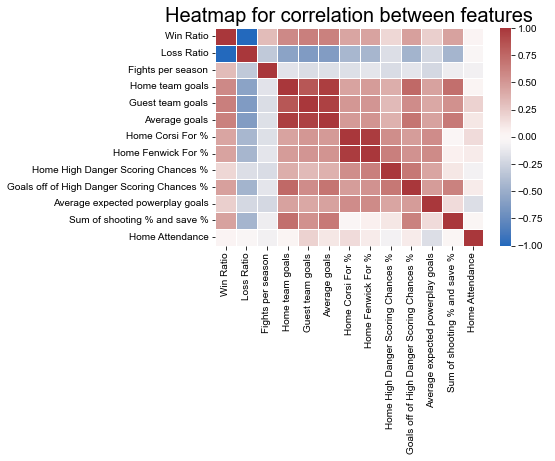

In [30]:
# display(merged)
fig = sns.heatmap(merged.corr(), linewidths=1, cmap="vlag")
fig.axes.set_title('Heatmap for correlation between features',fontsize=20)
sns.set(rc = {'figure.figsize':(12,12)})
plt.show()

In [31]:
features = list(merged.corr().loc['Fights per season', :].index)
del features[2]
correlation = list(merged.corr().loc['Fights per season', :].values)
del correlation[2]

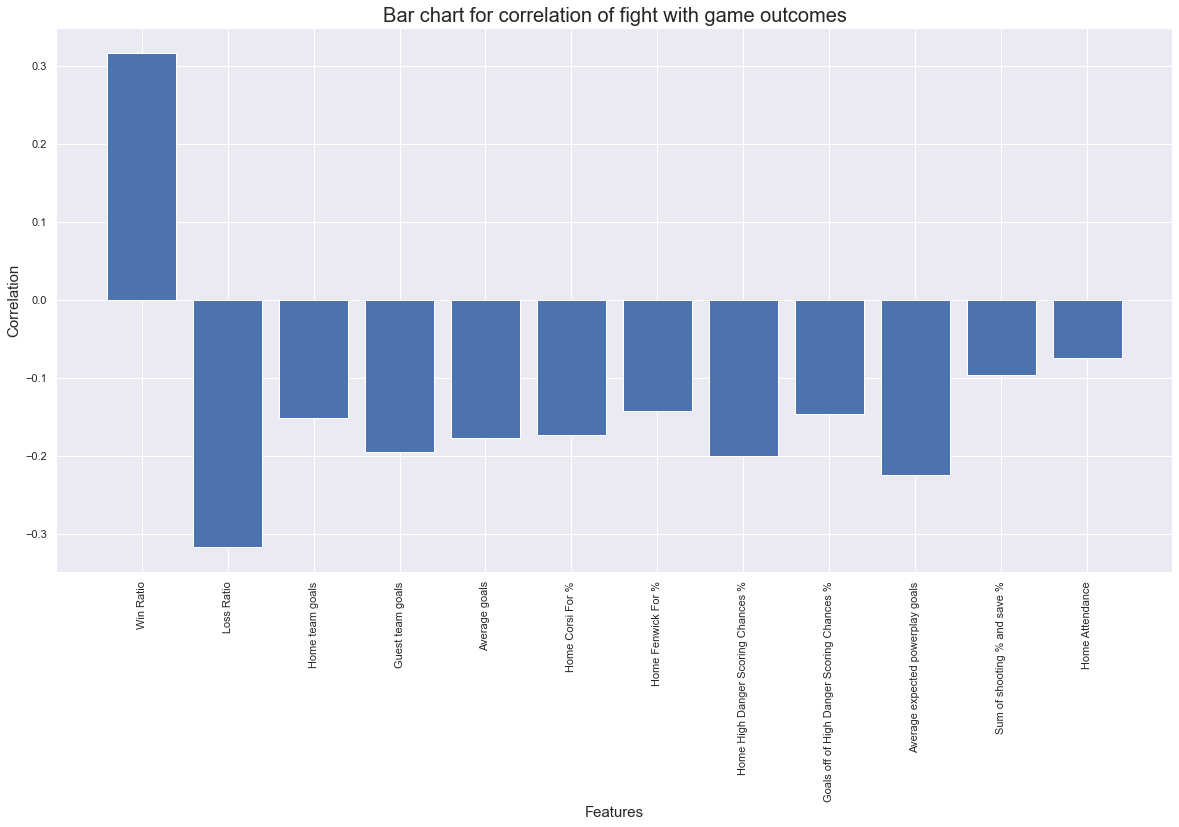

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x=features, height=correlation)
plt.xticks(rotation = 90)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)
ax.set_title('Bar chart for correlation of fight with game outcomes', fontsize=20)
plt.show()

In [33]:
abbr = [list(team_info.teams[idx].values())[4] for idx in range (team_info.shape[0])]
conference = [list((list(team_info.teams[idx].values())[9]).values())[1] for idx in range (team_info.shape[0])]
divison = [list(list(team_info.teams[idx].values())[8].values())[1] for idx in range (team_info.shape[0])]
abbr = [list(team_info.teams[idx].values())[4] for idx in range (team_info.shape[0])]

In [34]:
merged.set_index(['index'], inplace= True)
merged

,Win Ratio,Loss Ratio,Fights per season,Home team goals,Guest team goals,Average goals,Home Corsi For %,Home Fenwick For %,Home High Danger Scoring Chances %,Goals off of High Danger Scoring Chances %,Average expected powerplay goals,Sum of shooting % and save %,Home Attendance
index,,,,,,,,,,,,,
ANA,0.477407,0.522593,28.500000,2.752941,2.523622,2.638507,50.159882,50.431804,50.079252,49.879395,3.057216,1.006227,14609.235294
ARI,0.415822,0.584178,16.400000,2.800000,2.407258,2.602434,48.908286,48.541143,50.027531,47.207920,2.679143,1.005465,12061.967347
BOS,0.570896,0.429104,24.500000,3.258303,2.954717,3.108209,53.690332,53.992030,53.401328,54.994826,2.770295,1.006517,15310.656827
BUF,0.380130,0.619870,16.400000,2.632035,2.538793,2.585313,49.028528,49.010476,50.742130,41.791697,2.434502,0.990848,15978.155844
CAL,0.493124,0.506876,21.500000,3.226562,2.766798,2.998035,53.082578,52.706406,53.256797,53.288313,2.936523,0.990422,16177.199219
CAR,0.488142,0.511858,8.333333,3.000000,2.851562,2.924901,54.824480,54.542640,55.173145,53.375570,3.416880,0.996448,12266.432000
CBJ,0.482692,0.517308,19.000000,3.026515,2.683594,2.857692,50.437386,51.208333,51.135687,49.460720,2.853750,1.001258,14281.443182
CHI,0.481707,0.518293,11.666667,3.127572,2.839357,2.981707,50.927490,50.157490,47.949711,53.224130,2.823786,1.012198,18873.366255
COL,0.496198,0.503802,18.333333,3.249057,2.777778,3.015209,51.437245,51.562377,52.288826,51.525743,2.731660,1.005513,14126.520755


In [35]:
for idx, val in enumerate(abbr):
    for i in range(merged.shape[0]):
        if val == merged.index[i]:
            merged.loc[val,'conference'] = conference[i]
            merged.loc[val,'divison'] = divison[i]

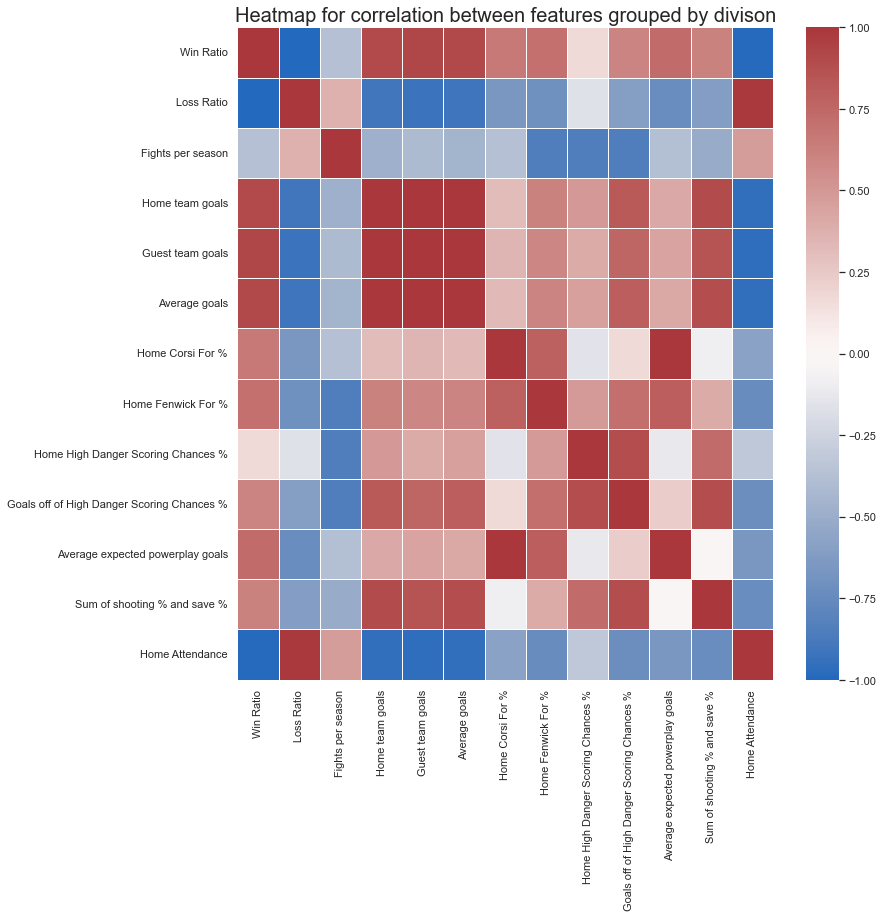

In [36]:
merged_div = merged.groupby('divison').mean()
fig = sns.heatmap(merged_div.corr(), linewidths=1, cmap="vlag")
fig.axes.set_title('Heatmap for correlation between features grouped by divison',fontsize=20)
sns.set(rc = {'figure.figsize':(12,12)})
plt.show()

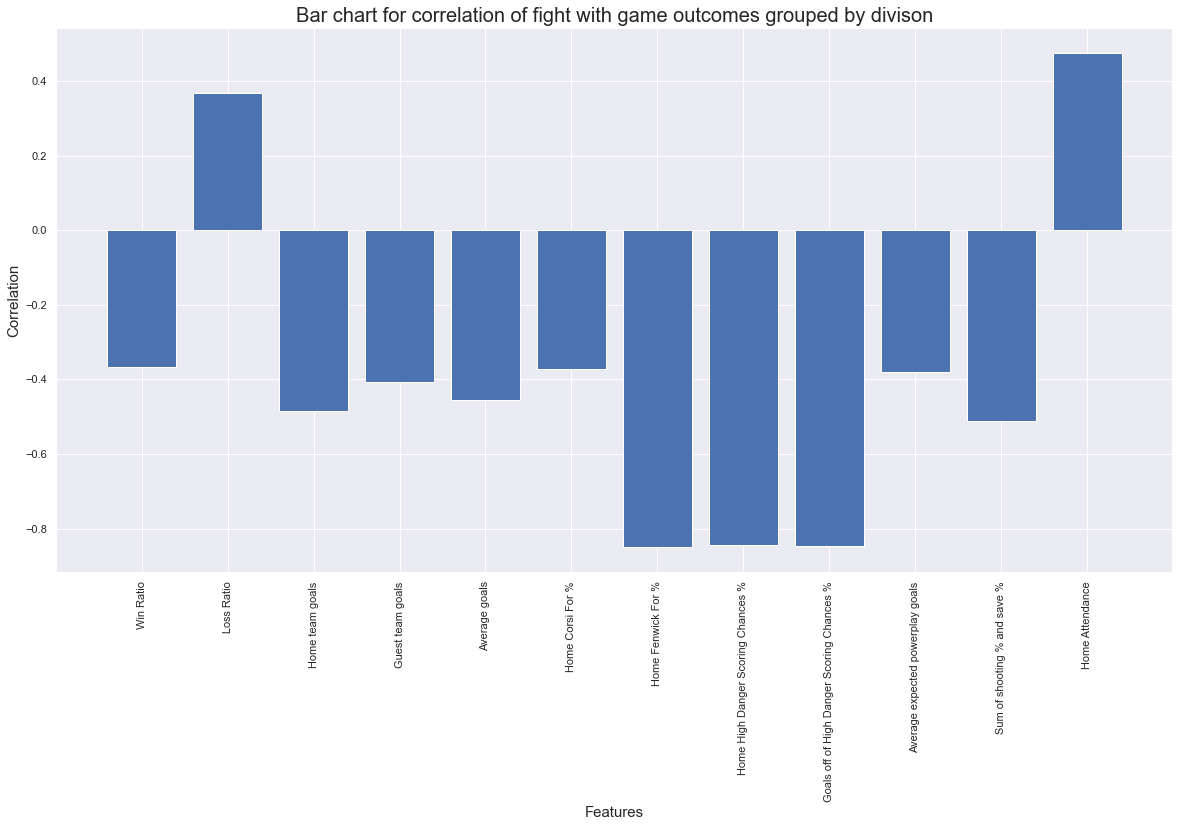

In [37]:
features = list(merged_div.corr().loc['Fights per season', :].index)
del features[2]
correlation = list(merged_div.corr().loc['Fights per season', :].values)
del correlation[2]

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x=features, height=correlation)
plt.xticks(rotation = 90)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)
ax.set_title('Bar chart for correlation of fight with game outcomes grouped by divison', fontsize=20)
plt.show()

In [38]:
match

,date,home_team,away_team,home_score,away_score,Host_won,home_CF%,guest_CF%,home_FF%,guest_FF%,home_HDCF%,guest_HDCF%,home_HDGF%,guest_HDGF%,home_xGF_pp,guest_xGF_pp,home_PDO,guest_PDO,home_Attendance
0,2015-10-07,TOR,MON,1,3,0,55.00,45.00,53.13,46.88,68.42,31.58,0.00,100.00,3.14,2.58,0.924,1.076,19241.0
1,2015-10-07,CHI,NYR,2,3,0,60.58,39.42,55.81,44.19,43.48,56.52,66.67,33.33,2.45,2.93,0.948,1.052,22104.0
2,2015-10-07,CAL,VAN,1,5,0,45.38,54.62,42.71,57.29,40.00,60.00,25.00,75.00,2.62,3.55,0.920,1.080,19289.0
3,2015-10-07,LAK,SJS,1,5,0,44.90,55.10,41.33,58.67,27.27,72.73,33.33,66.67,1.52,2.61,0.894,1.106,18230.0
4,2015-10-08,BOS,WPG,2,6,0,55.75,44.25,54.95,45.05,57.14,42.86,25.00,75.00,3.24,2.63,0.877,1.123,17565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7861,2021-06-28,TBL,MON,5,1,1,47.42,52.58,53.25,46.75,58.82,41.18,100.00,0.00,3.04,1.85,1.133,0.867,15911.0
7862,2021-06-30,TBL,MON,3,1,1,40.71,59.29,40.45,59.55,41.18,58.82,100.00,0.00,1.93,3.10,1.107,0.893,17166.0
7863,2021-07-02,MON,TBL,3,6,0,55.14,44.86,55.42,44.58,41.18,58.82,0.00,100.00,2.13,3.20,0.886,1.114,3500.0
7864,2021-07-05,MON,TBL,3,2,1,37.50,62.50,33.77,66.23,30.43,69.57,50.00,50.00,1.70,4.20,1.084,0.916,3500.0


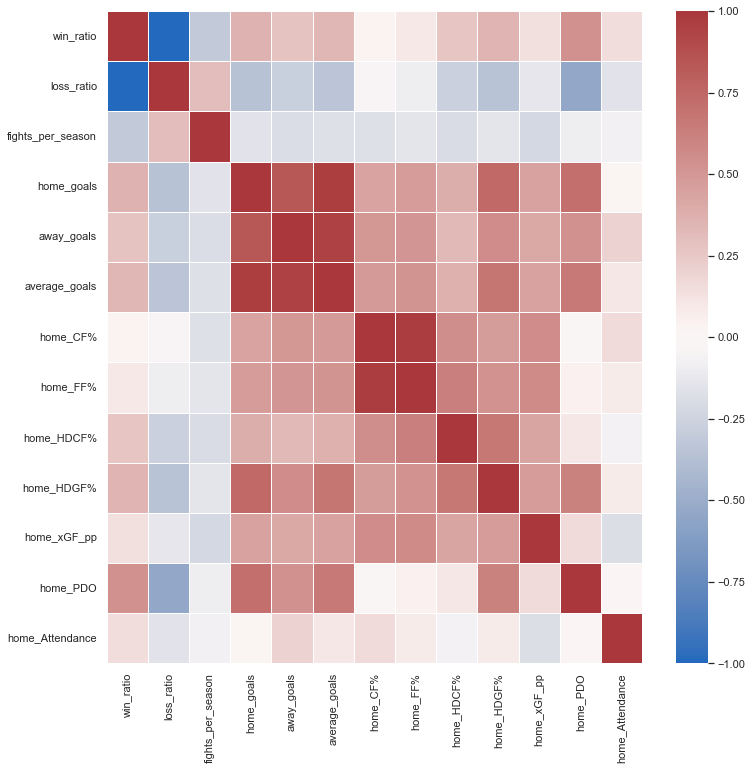

In [39]:
max_fight_team_df = match[(match['home_team'] == max_fight_team) | (match['away_team'] == max_fight_team)]
max_fight_team_df.reset_index(inplace=True, drop=True)
max_fight_team_df.head()
win = []
loss = []
for val in range(max_fight_team_df.shape[0]):
    if max_fight_team_df.loc[val, 'Host_won'] == 1:
        win.append(max_fight_team_df.loc[val, 'home_team'])
        loss.append(max_fight_team_df.loc[val, 'away_team'])
    else:
        win.append(max_fight_team_df.loc[val, 'away_team'])
        loss.append(max_fight_team_df.loc[val, 'home_team'])
win_ratio = pd.Series(win).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
loss_ratio = pd.Series(loss).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
final_df = pd.DataFrame()
final_df['win_ratio'] = win_ratio
final_df['loss_ratio'] = loss_ratio
fights_per_season = []
for val in sorted(total_fights.keys()):
    final_df.loc[val, 'fights_per_season'] = total_fights[val]
final_df.corr(method='spearman')
home_goals = match.groupby(['home_team'])['home_score'].sum()
away_goals = match.groupby(['away_team'])['away_score'].sum()
final_df['home_goals'] = home_goals / match['home_team'].value_counts().sort_index()
final_df['away_goals'] = away_goals / match['away_team'].value_counts().sort_index()
final_df['average_goals'] = (home_goals + away_goals) / (match['home_team'].value_counts().sort_index() + match['away_team'].value_counts().sort_index())
for val in match.columns[6::2]:
    final_df[val] = match.groupby(['home_team'])[val].mean()
sns.heatmap(final_df.corr(), linewidths=1, cmap="vlag")
sns.set(rc = {'figure.figsize':(25,25)})
plt.show()
# max_fight_team_df.head()

In [40]:
def team_correlation(team, message1, message2):

    df = match[(match['home_team'] == team) | (match['away_team'] == team)]
    df.reset_index(inplace=True, drop=True)
    
    win = []
    loss = []
    
    for val in range(df.shape[0]):
        if df.loc[val, 'Host_won'] == 1:
            win.append(df.loc[val, 'home_team'])
            loss.append(df.loc[val, 'away_team'])
        else:
            win.append(df.loc[val, 'away_team'])
            loss.append(df.loc[val, 'home_team'])
            
    win_ratio = pd.Series(win).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
    loss_ratio = pd.Series(loss).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
    
    final_df = pd.DataFrame()
    
    final_df['win_ratio'] = win_ratio
    final_df['loss_ratio'] = loss_ratio
    
    fights_per_season = []
    
    for val in sorted(total_fights.keys()):
        final_df.loc[val, 'fights_per_season'] = total_fights[val]
        
    final_df.corr(method='spearman')
    
    home_goals = match.groupby(['home_team'])['home_score'].sum()
    away_goals = match.groupby(['away_team'])['away_score'].sum()
    
    final_df['home_goals'] = home_goals / match['home_team'].value_counts().sort_index()
    final_df['away_goals'] = away_goals / match['away_team'].value_counts().sort_index()
    
    final_df['average_goals'] = (home_goals + away_goals) / (match['home_team'].value_counts().sort_index() \
                                                             + match['away_team'].value_counts().sort_index())
    
    for val in match.columns[6::2]:
        final_df[val] = match.groupby(['home_team'])[val].mean()
        
    rename_features(final_df)
    
    fig = sns.heatmap(final_df.corr(), linewidths=1, cmap="vlag")
    fig.axes.set_title(message1,fontsize=20)
    sns.set(rc = {'figure.figsize':(12,12)})
    plt.show()
    
    features = list(final_df.corr().loc['Fights per season', :].index)
    del features[2]
    correlation = list(final_df.corr().loc['Fights per season', :].values)
    del correlation[2]

    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(x=features, height=correlation)
    plt.xticks(rotation = 90)
    ax.set_xlabel('Features', fontsize=15)
    ax.set_ylabel('Correlation', fontsize=15)
    ax.set_title(message2, fontsize=20)
    plt.show()

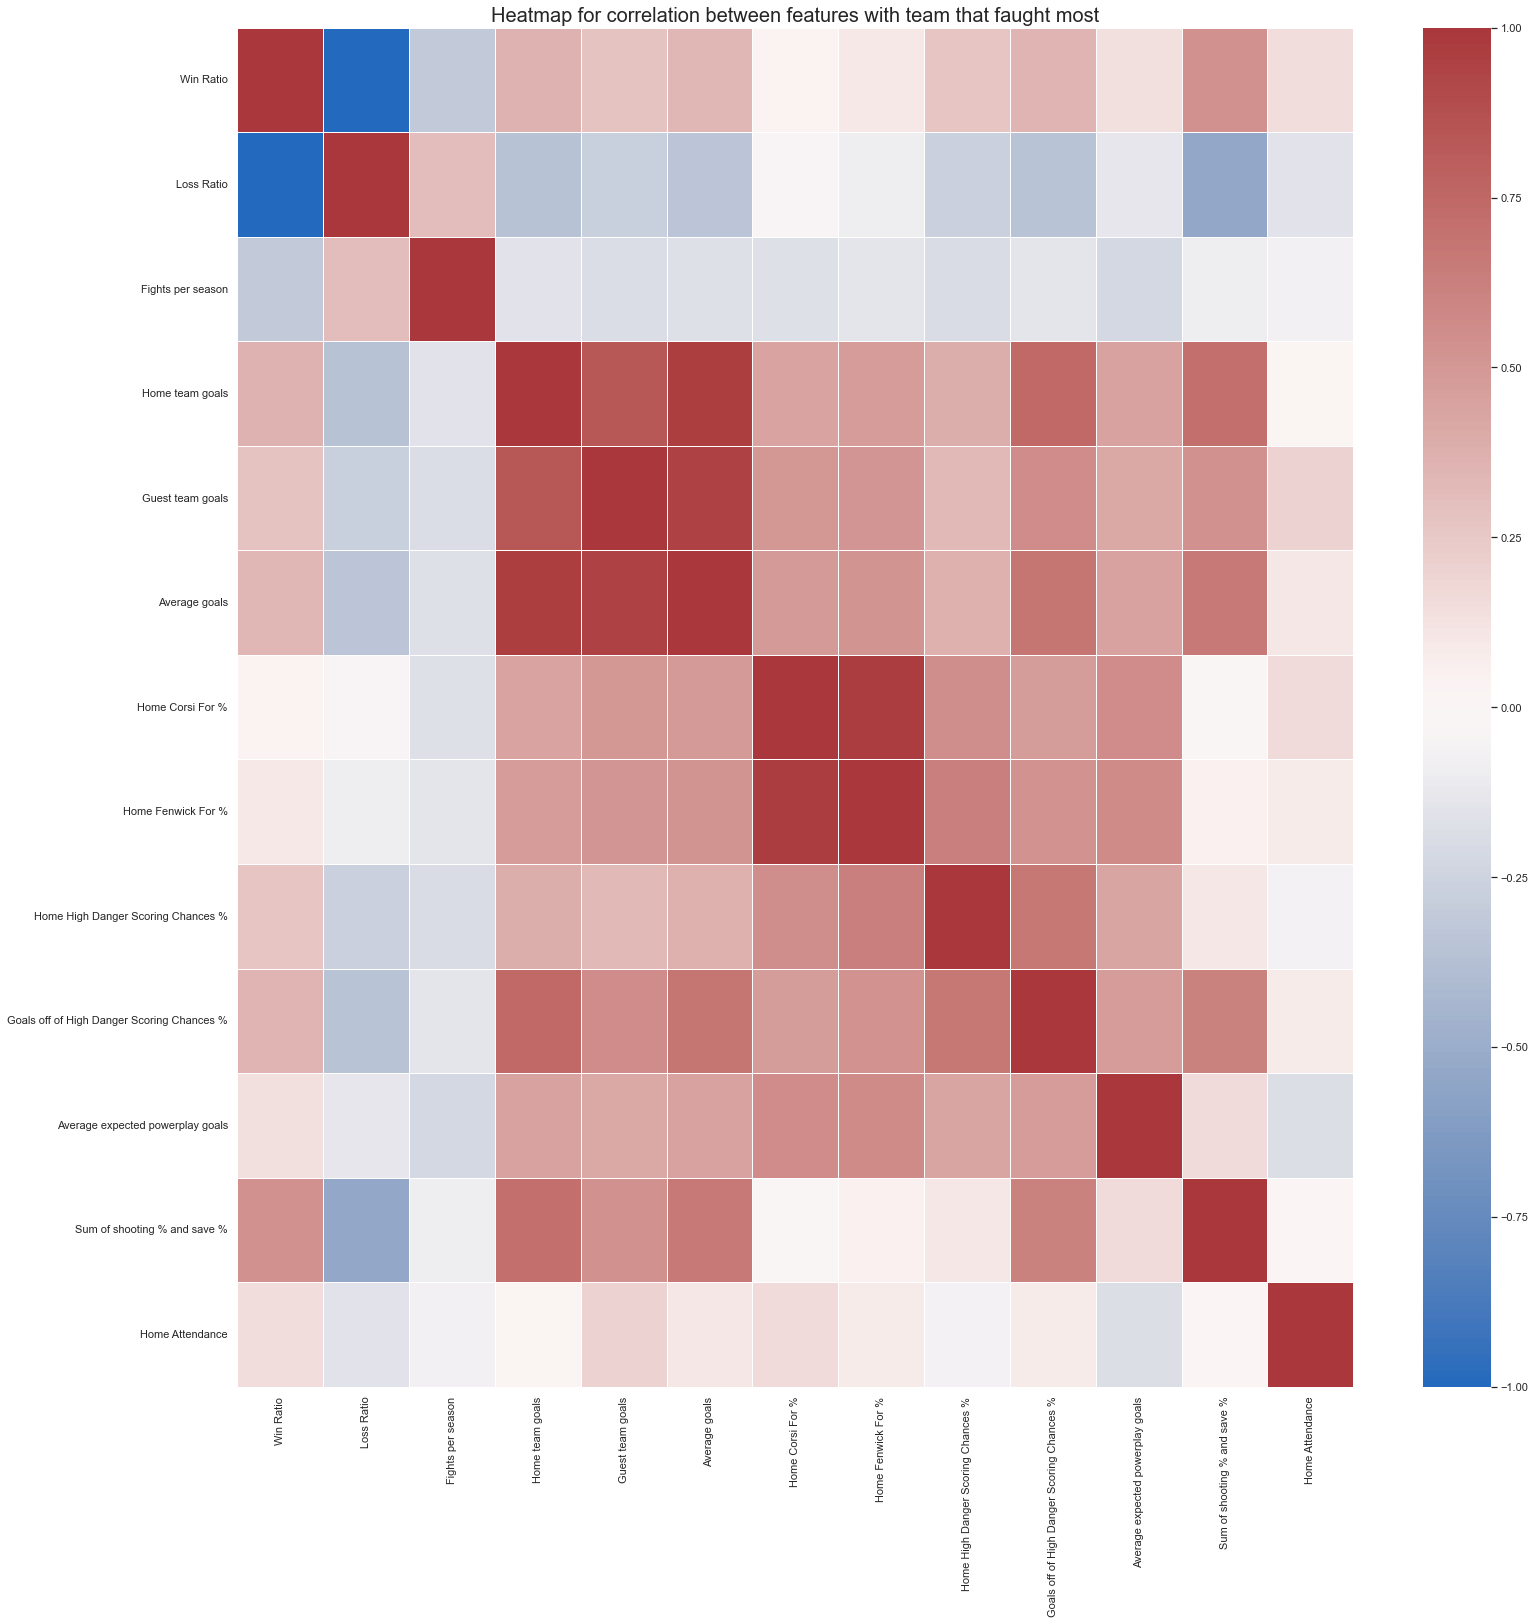

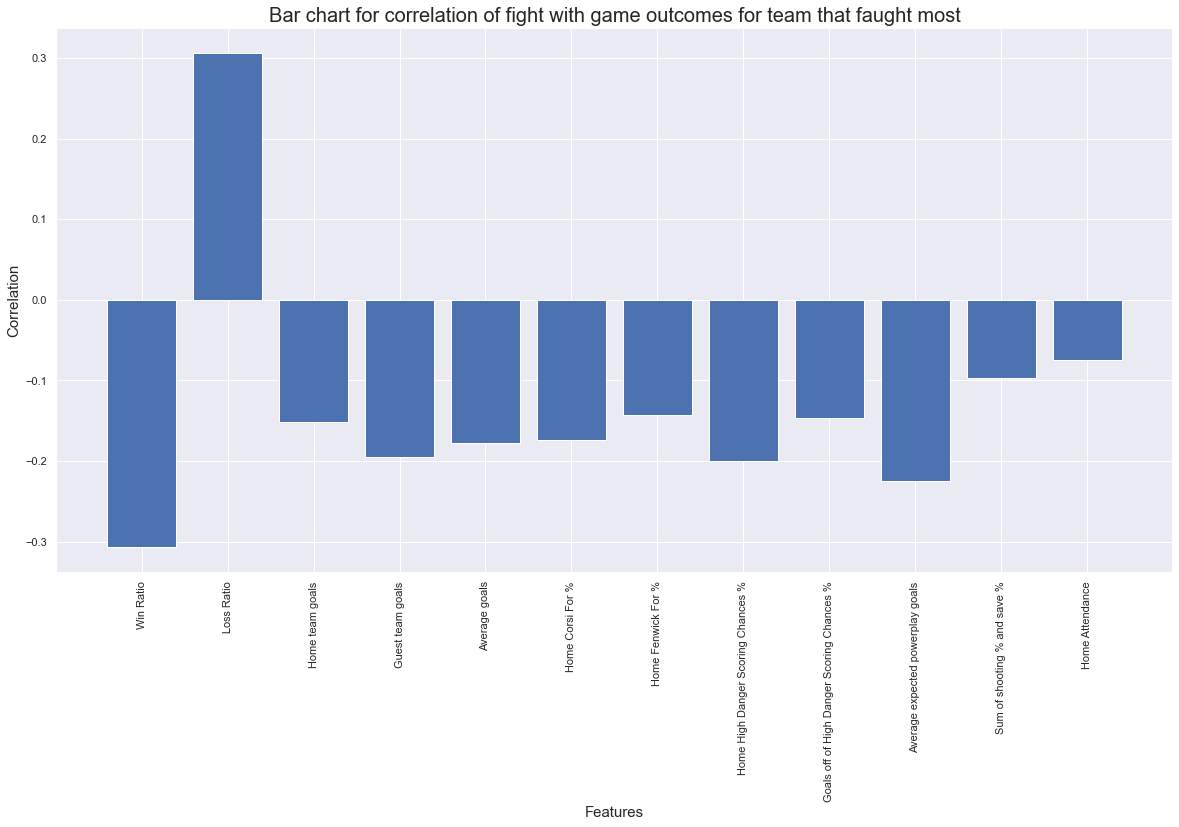

In [41]:
team_correlation(max_fight_team, 'Heatmap for correlation between features with team that faught most', \
                'Bar chart for correlation of fight with game outcomes for team that faught most')

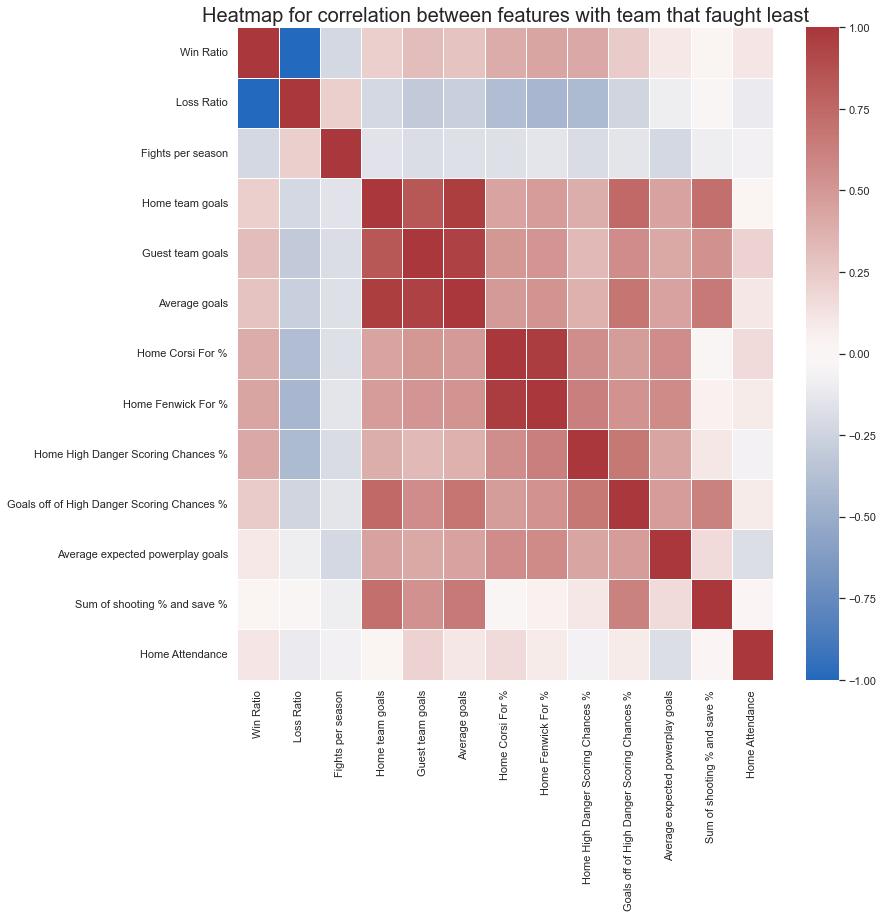

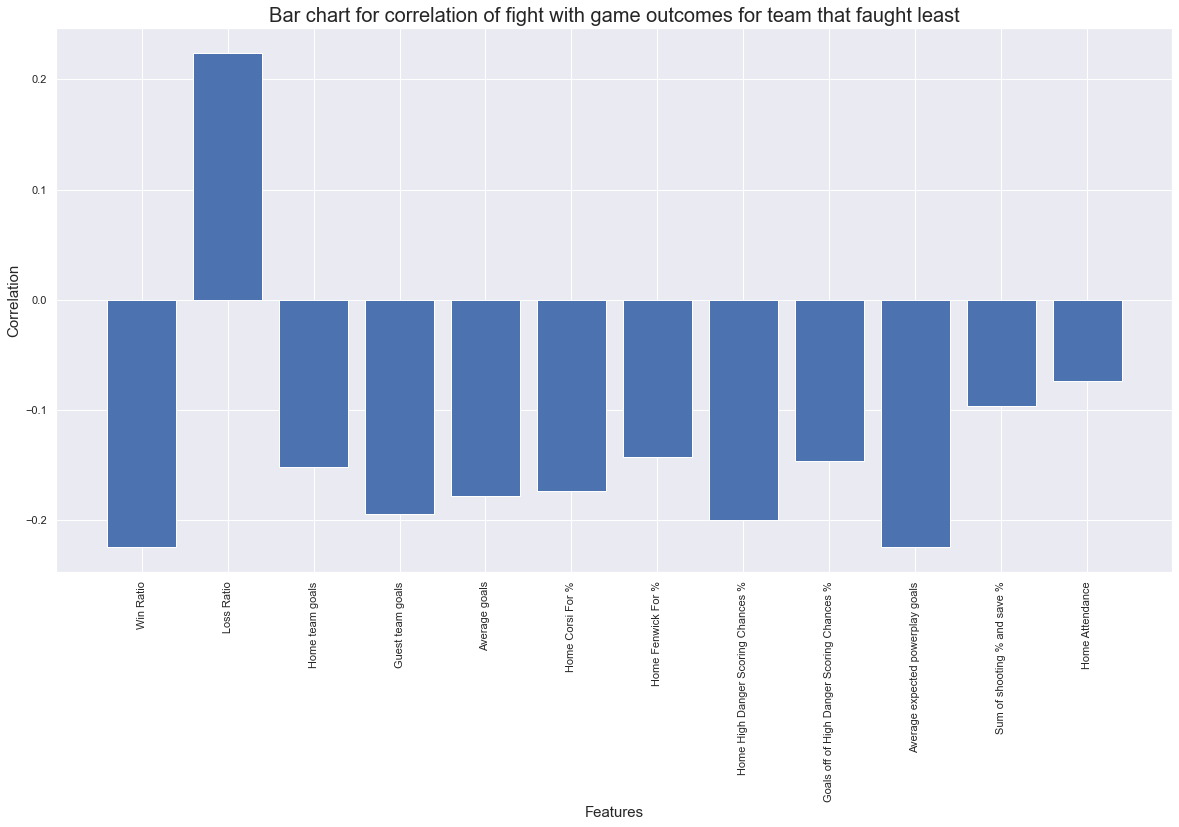

In [42]:
team_correlation(min_fight_team, 'Heatmap for correlation between features with team that faught least', \
                'Bar chart for correlation of fight with game outcomes for team that faught least')

In [43]:
fight

,date_of_fight,idk_column,player1_name,player1_team,player2_name,player2_team,winner,Voted winner (%),Voted rating
0,2015-04-11,1 Pd 19:14,Eric Boulton,NYI,Dalton Prout,CBJ,Voted winner: Dalton Prout (42.9%) - Voted rat...,42.9,6.63
1,2015-04-11,3 Pd 10:24,Tim Gleason,WAS,Tanner Glass,NYR,Voted winner: Tim Gleason (38.7%) - Voted rati...,38.7,7.59
2,2015-04-09,2 Pd 14:37,Alex Petrovic,FLA,Adam McQuaid,BOS,Voted winner: Adam McQuaid (61%) - Voted ratin...,61,5.6
3,2015-04-09,1 Pd 18:51,Vincent Lecavalier,PHI,Keegan Lowe,CAR,Voted winner: Keegan Lowe (88.3%) - Voted rati...,88.3,6.33
4,2015-04-09,2 Pd 7:30,Brandon Manning,PHI,Brad Malone,CAR,Voted winner: Brandon Manning (75.6%) - Voted ...,75.6,3.47
...,...,...,...,...,...,...,...,...,...
1613,2019-10-08,2 Pd 6:9,Milan Lucic,CAL,Kurtis MacDermid,LAK,Voted winner: Milan Lucic (36.2%) - Voted rati...,36.2,4.73
1614,2019-10-08,1 Pd 14:0,Austin Watson,NSH,Trevor Carrick,SJS,Voted winner: Trevor Carrick (53.2%) - Voted r...,53.2,2.68
1615,2019-10-05,1 Pd 11:28,Nicolas Deslauriers,ANA,Brenden Dillon,SJS,Voted winner: Nicolas Deslauriers (85.3%) - Vo...,85.3,6.61
1616,2019-10-05,2 Pd 15:9,Sidney Crosby,PIT,Pierre-Luc Dubois,CBJ,Voted winner: Sidney Crosby (56.9%) - Voted ra...,56.9,2.89


In [44]:
match['date'] = pd.to_datetime(match['date'])

In [45]:
def categorise(row):
    
    for idx in range(fight.shape[0]):
        if ((fight.loc[idx, 'date_of_fight'] == row['date']) and \
            (fight.loc[idx, 'player1_team'] == row['home_team']) and \
            (fight.loc[idx, 'player2_team'] == row['away_team'])):
            return 1

match['fight'] = match.apply(lambda row: categorise(row), axis=1)
match['fight'] = match['fight'].fillna(0)

In [46]:
def categorise(row):
    if row['home_score'] > row['away_score']:
        return 1
    else:
        return 0

match['home_team_won'] = match.apply(lambda row: categorise(row), axis=1)

In [47]:
def categorise(row):
    if row['home_score'] < row['away_score']:
        return 1
    else:
        return 0

match['away_team_won'] = match.apply(lambda row: categorise(row), axis=1)

In [48]:
match.head()

,date,home_team,away_team,home_score,away_score,Host_won,home_CF%,guest_CF%,home_FF%,guest_FF%,...,home_HDGF%,guest_HDGF%,home_xGF_pp,guest_xGF_pp,home_PDO,guest_PDO,home_Attendance,fight,home_team_won,away_team_won
0,2015-10-07,TOR,MON,1,3,0,55.00,45.00,53.13,46.88,...,0.00,100.00,3.14,2.58,0.924,1.076,19241.0,0.0,0,1
1,2015-10-07,CHI,NYR,2,3,0,60.58,39.42,55.81,44.19,...,66.67,33.33,2.45,2.93,0.948,1.052,22104.0,0.0,0,1
2,2015-10-07,CAL,VAN,1,5,0,45.38,54.62,42.71,57.29,...,25.00,75.00,2.62,3.55,0.920,1.080,19289.0,1.0,0,1
3,2015-10-07,LAK,SJS,1,5,0,44.90,55.10,41.33,58.67,...,33.33,66.67,1.52,2.61,0.894,1.106,18230.0,1.0,0,1
4,2015-10-08,BOS,WPG,2,6,0,55.75,44.25,54.95,45.05,...,25.00,75.00,3.24,2.63,0.877,1.123,17565.0,0.0,0,1


In [49]:
fight = match[match['fight'] == 1]
fight.reset_index(inplace= True, drop= True)

In [50]:
features = ['fight_1', 'fight_2', 'fight','home_score_2', 'home_score_1', \
            'home_score', 'home_CF%_2', 'home_CF%_1', 'home_CF%','home_FF%_2', \
            'home_FF%_1', 'home_FF%', 'home_HDCF%_2', 'home_HDCF%_1', 'home_HDCF%', \
            'home_HDGF%_2', 'home_HDGF%_1', 'home_HDGF%','home_PDO_2', 'home_PDO_1', \
            'home_PDO', 'home_Attendance_2', 'home_Attendance_1', \
            'home_Attendance', 'home_team_won_2', 'home_team_won_1', 'home_team_won', \
            'home_score_2', 'home_score_1', 'home_score', \
            'home_xGF_pp_2', 'home_xGF_pp_1', 'home_xGF_pp', 'home_PDO_2', 'home_PDO_1', \
            'home_PDO']

In [51]:
def rename_features(df):
    df.rename(columns={'fight_1': 'Fights in current match', \
                       'home_score_2': 'Goals by home team in current match', \
                       'home_score_1': 'Goals by home team in next match', \
                       'home_score': 'Goals by home team in next to next match', \
                       'home_CF%_2': 'Home Corsi For % in current match', \
                       'home_CF%_1': 'Home Corsi For % in next match', \
                       'home_CF%': 'Home Corsi For % in next to next match', \
                       'home_FF%_2': 'Home Fenwick For % in current match', \
                       'home_FF%_1': 'Home Fenwick For % in next match', \
                       'home_FF%': 'Home Fenwick For % in next to next match', \
                       'home_HDCF%_2': 'Home High Danger Scoring Chances % in current match', \
                       'home_HDCF%_1': 'Home High Danger Scoring Chances % in next match', \
                       'home_HDCF%': 'Home High Danger Scoring Chances % in next to next match', \
                       'home_Attendance_2': 'Home attendance in current match', \
                       'home_Attendance_1': 'Home attendance in next match', \
                       'home_Attendance': 'Home attendance in next to match', \
                       'home_team_won_2': 'Home team won in current match', \
                       'home_team_won_1': 'Home team won in next match', \
                       'home_team_won': 'Home team won in next to next match'}, inplace= True)

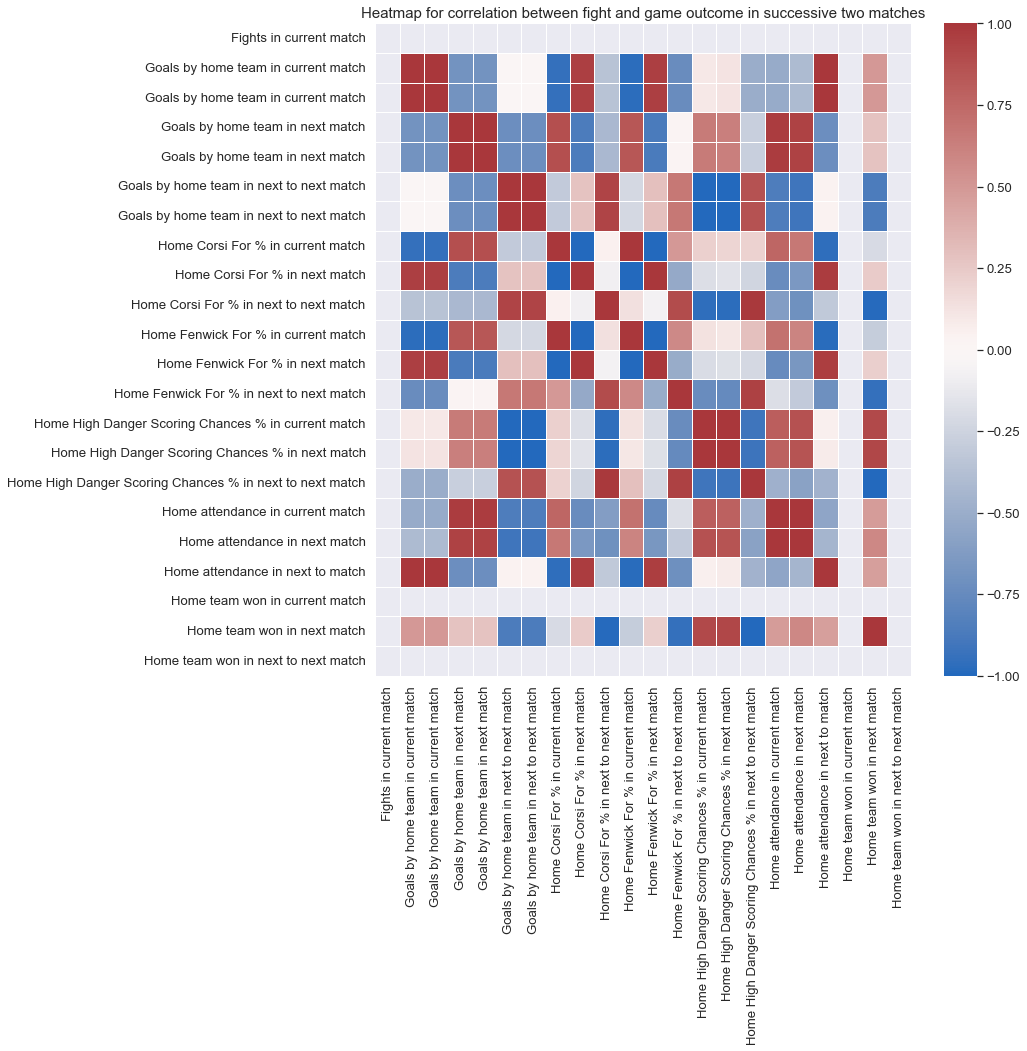

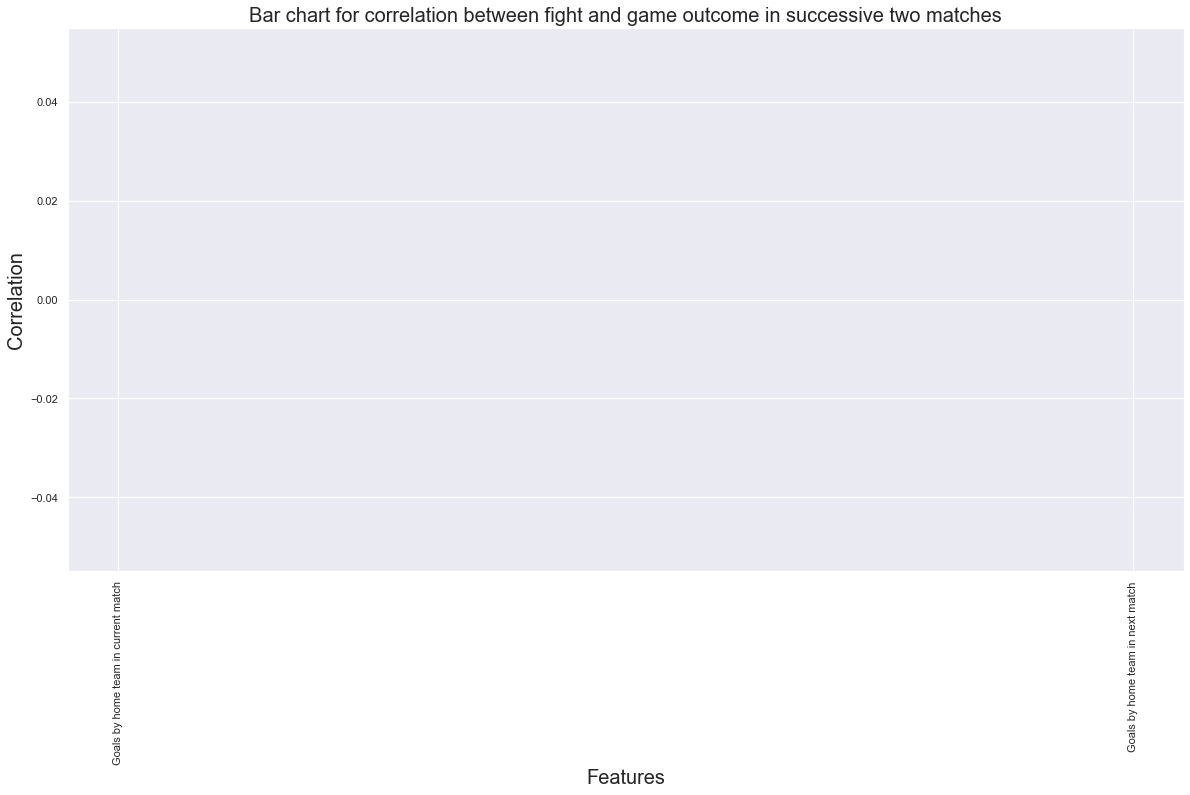

In [52]:
def upcoming_match_correlation(team_a, team_b):
    fight_index = set(fight[(fight['home_team'] == team_a) | (fight['away_team'] == team_b)].index)
    match_index = match[(match['home_team'] == team_a) | (match['away_team'] == team_b)].index

    df = pd.DataFrame()
    for idx in range(len(match_index)):
        if match_index[idx] in fight_index:
            s1 = match.iloc[match_index[idx], :]
            s1 = s1.add_suffix('_1')

            if idx+1 < len(match_index):
                s2 = match.iloc[match_index[idx+1], :]
                s2 = s2.add_suffix('_2')
                s1 = pd.concat([s1,s2])

            if idx+2 < len(match_index):
                s3 = match.iloc[match_index[idx+2], :]
                s1 = pd.concat([s1,s3])
            df = df.append(s1, ignore_index=True)
    df = df[features]
    df = df[['fight_1', 'home_score_2', 'home_score_1', \
             'home_score', 'home_CF%_2', 'home_CF%_1', 'home_CF%', 'home_FF%_2', \
             'home_FF%_1', 'home_FF%', 'home_HDCF%_2', 'home_HDCF%_1', 'home_HDCF%', \
             'home_Attendance_2', 'home_Attendance_1', 'home_Attendance', \
             'home_team_won_2', 'home_team_won_1', 'home_team_won']]
    
    rename_features(df)
    sns.set(font_scale = 1.2)
    fig = sns.heatmap(df.corr(), linewidths=1, cmap = 'vlag')
    fig.axes.set_title('Heatmap for correlation between fight and game outcome in successive two matches', \
                       fontsize=15)
    sns.set(rc = {'figure.figsize':(10,10)})
    
    feature = df.corr().loc[:, 'Fights in current match'].index[1:]
    values = list(df.corr().loc[:, 'Fights in current match'].values[1:])
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(x=feature, height=values)
    plt.xticks(rotation = 90)
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('Correlation', fontsize=20)
    ax.set_title('Bar chart for correlation between fight and game outcome in successive two matches', \
                 fontsize=20)
    plt.rcParams.update({'font.size': 25})
    plt.show()

In [ ]:
upcoming_match_correlation('VAN', 'TOR')